In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/samples.zip

Streaming output truncated to the last 5000 lines.
  inflating: samples/X/1002.png      
  inflating: samples/X/1003.png      
  inflating: samples/X/1004.png      
  inflating: samples/X/1005.png      
  inflating: samples/X/1006.png      
  inflating: samples/X/1007.png      
  inflating: samples/X/1008.png      
  inflating: samples/X/1009.png      
  inflating: samples/X/1010.png      
  inflating: samples/X/1011.png      
  inflating: samples/X/1012.png      
  inflating: samples/X/1013.png      
  inflating: samples/X/1014.png      
  inflating: samples/X/1015.png      
  inflating: samples/X/1016.png      
  inflating: samples/X/1017.png      
  inflating: samples/X/1018.png      
  inflating: samples/X/1019.png      
  inflating: samples/X/1020.png      
  inflating: samples/X/1021.png      
  inflating: samples/X/1022.png      
  inflating: samples/X/1023.png      
  inflating: samples/X/1024.png      
  inflating: samples/X/1025.png      
  inflating: samples/X/1026.png      

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
batch_size = 16
image_size = 75
num_classes = 29
epochs = 50
train_len = 58000

In [5]:
train_dir = '/content/samples'

In [6]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
def load_data(train_dir, image_size):
    images = []
    labels = []
    class_names = os.listdir(train_dir)

    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(class_names.index(class_name))

    return np.array(images), np.array(labels)

In [8]:
X, y = load_data(train_dir, image_size)
y = to_categorical(y, num_classes)

In [9]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

In [13]:
validation_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [14]:
# Model creation
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)

predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=4)
checkpoint_filepath = 'checkpoints/best_model_inceptionresnet.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [18]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stop, model_checkpoint_callback],
    verbose=2
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2538/2538 - 1116s - 440ms/step - accuracy: 0.7997 - loss: 0.7036 - val_accuracy: 0.9317 - val_loss: 0.2278
Epoch 2/50
2538/2538 - 144s - 57ms/step - accuracy: 0.8838 - loss: 0.3833 - val_accuracy: 0.9501 - val_loss: 0.1596
Epoch 3/50
2538/2538 - 125s - 49ms/step - accuracy: 0.9040 - loss: 0.3150 - val_accuracy: 0.9541 - val_loss: 0.1509
Epoch 4/50
2538/2538 - 126s - 50ms/step - accuracy: 0.9149 - loss: 0.2835 - val_accuracy: 0.9661 - val_loss: 0.1188
Epoch 5/50
2538/2538 - 123s - 49ms/step - accuracy: 0.9188 - loss: 0.2705 - val_accuracy: 0.9643 - val_loss: 0.1223
Epoch 6/50
2538/2538 - 143s - 56ms/step - accuracy: 0.9225 - loss: 0.2579 - val_accuracy: 0.9743 - val_loss: 0.0866
Epoch 7/50
2538/2538 - 124s - 49ms/step - accuracy: 0.9288 - loss: 0.2419 - val_accuracy: 0.9757 - val_loss: 0.0857
Epoch 8/50
2538/2538 - 140s - 55ms/step - accuracy: 0.9312 - loss: 0.2326 - val_accuracy: 0.9648 - val_loss: 0.1248
Epoch 9/50
2538/2538 - 122s - 48ms/step - accuracy: 0.9355 - loss: 0.2223 - val_a

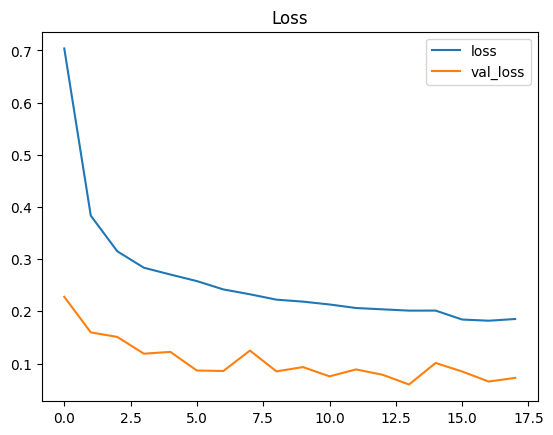

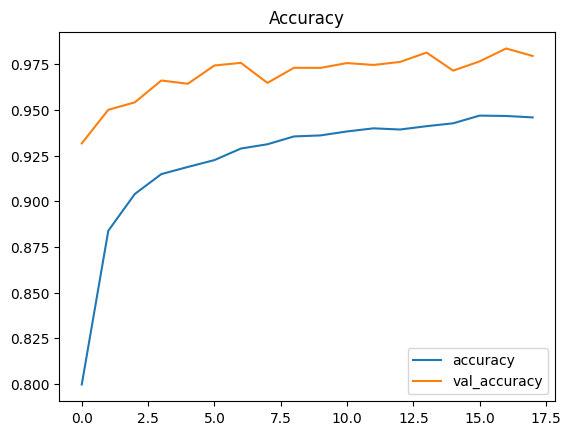

In [19]:
metrics = pd.DataFrame(history.history)

metrics[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

metrics[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.show()

In [20]:
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=0)
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")

Validation Accuracy: 97.95%


In [ ]:
predictions = model.predict(validation_generator)
predictions_classes = np.argmax(predictions, axis=1)

In [ ]:
y_true = validation_generator.classes

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(confusion_matrix(y_true, predictions_classes), annot=True)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('InceptionResNetV2.h5')


In [ ]:
print(predictions_classes)
print(y_true)